# Data visualization

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from pandas.api.types import CategoricalDtype

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [8]:
df=pd.read_excel("/home/kamal/Desktop/ULI-3/FinalDataset/BNA(10-22).xlsx")
df.head()

,DATE,Wind_Direction,Wind_Speed,cloud_height,vis_distance,Temp,Dew_Point,Slp,Departure,Arrival,Airport
0,2010-01-01 00:00:00,330.000000,3.350000,259.000000,16046.5,278.950000,276.300000,510.350000,5,4,BNA
1,2010-01-01 01:00:00,330.000000,3.100000,762.000000,16093.0,278.150000,275.350000,1021.300000,0,0,BNA
2,2010-01-01 02:00:00,330.000000,2.100000,457.000000,16093.0,278.150000,275.950000,1021.700000,0,0,BNA
3,2010-01-01 03:00:00,343.333333,3.266667,609.333333,16062.0,277.083333,274.216667,681.466667,0,0,BNA
4,2010-01-01 04:00:00,340.000000,4.100000,1036.000000,16093.0,277.050000,273.750000,1022.400000,0,0,BNA


In [9]:
df['Flights'] = df['Departure'] + df['Arrival']

In [10]:
df.drop(columns=['Departure', 'Arrival','Airport'], inplace=True)
df.head()

,DATE,Wind_Direction,Wind_Speed,cloud_height,vis_distance,Temp,Dew_Point,Slp,Flights
0,2010-01-01 00:00:00,330.000000,3.350000,259.000000,16046.5,278.950000,276.300000,510.350000,9
1,2010-01-01 01:00:00,330.000000,3.100000,762.000000,16093.0,278.150000,275.350000,1021.300000,0
2,2010-01-01 02:00:00,330.000000,2.100000,457.000000,16093.0,278.150000,275.950000,1021.700000,0
3,2010-01-01 03:00:00,343.333333,3.266667,609.333333,16062.0,277.083333,274.216667,681.466667,0
4,2010-01-01 04:00:00,340.000000,4.100000,1036.000000,16093.0,277.050000,273.750000,1022.400000,0


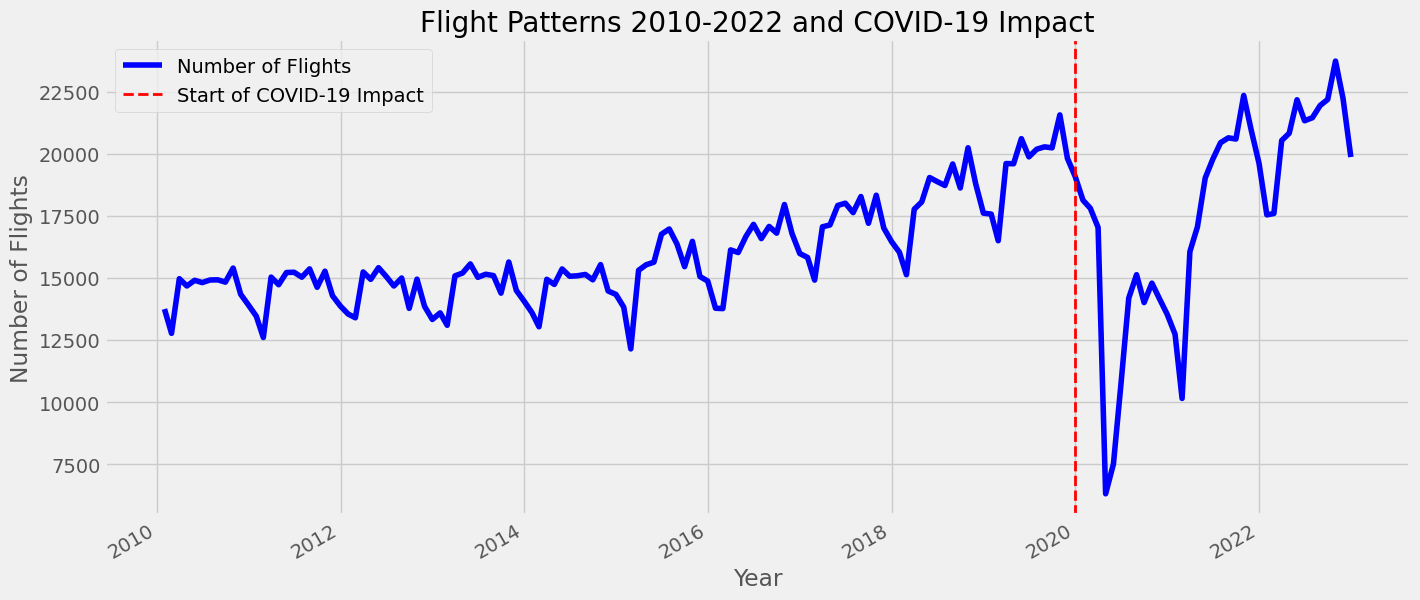

In [11]:
# Ensure the DATE column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Aggregate data on a monthly basis for clearer visualization
# This groups data by month and year, then sums up the flights for each month
df_monthly = df.resample('M', on='DATE').sum()
df_monthly.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(15, 7))  # Set the figure size for better readability
plt.plot(df_monthly['DATE'], df_monthly['Flights'], label='Number of Flights', color='blue')

# Highlighting COVID-19 impact period from early 2020
plt.axvline(pd.to_datetime('2020-01-01'), color='r', linestyle='--', lw=2, label='Start of COVID-19 Impact')

plt.title('Flight Patterns 2010-2022 and COVID-19 Impact')
plt.xlabel('Year')
plt.ylabel('Number of Flights')
plt.legend()

# Improve readability of the x-axis dates
plt.gcf().autofmt_xdate()

plt.show()

In [12]:
df['DATE'] = pd.to_datetime(df['DATE'])
# Defining the categorical type for weekdays
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date_offset'] = (df.index.month*100 + df.index.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Flights')
features_and_target = pd.concat([X, y], axis=1)

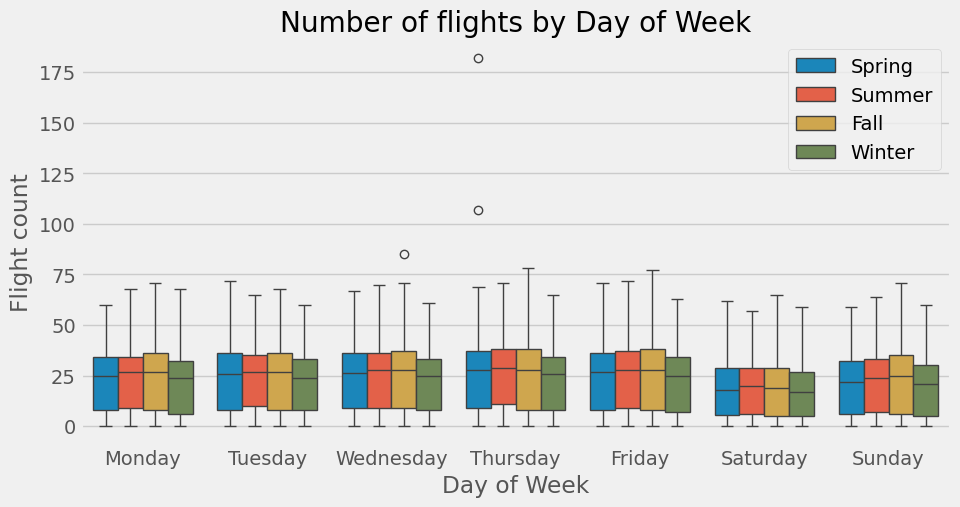

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Flights',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Number of flights by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Flight count')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Training Model

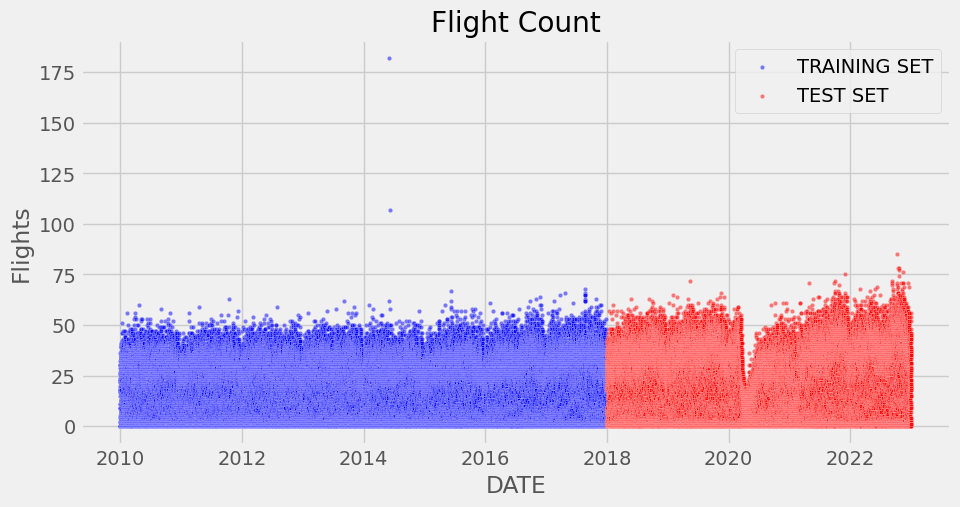

In [14]:
df['DATE'] = pd.to_datetime(df['DATE'])

split_date = pd.Timestamp('2017-12-31 23:00:00')
df_train = df[df['DATE'] <= split_date]
df_test = df[df['DATE'] > split_date]


# Plot train and test so you can see where we have split
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_train['DATE'], y=df_train['Flights'], data=df_train, color='blue', s=10, alpha=0.5, label='TRAINING SET')
sns.scatterplot(x=df_test['DATE'], y=df_test['Flights'], data=df_test, color='red', s=10, alpha=0.5, label='TEST SET')
plt.title('Flight Count')
plt.legend()
plt.show()

In [15]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.rename(columns={'DATE':'ds','Flights':'y'})

In [16]:
%%time
model = Prophet()
model.fit(df_train_prophet)

12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4.1 s, sys: 92.2 ms, total: 4.19 s
Wall time: 20 s


# Forecasting

In [17]:
# Predict on test set with model
df_test_prophet = df_test.rename(columns={'DATE':'ds','Flights':'y'})

df_test_fcst = model.predict(df_test_prophet)

In [18]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,24.020583,-0.998464,13.265999,24.020583,24.020583,-18.269190,-18.269190,-18.269190,-14.740748,...,-0.313010,-0.313010,-0.313010,-3.215432,-3.215432,-3.215432,0.0,0.0,0.0,5.751393
1,2018-01-01 01:00:00,24.020701,-3.323575,10.532000,24.020701,24.020701,-20.738588,-20.738588,-20.738588,-17.363648,...,-0.159433,-0.159433,-0.159433,-3.215507,-3.215507,-3.215507,0.0,0.0,0.0,3.282113
2,2018-01-01 02:00:00,24.020819,-7.185566,7.928763,24.020819,24.020819,-23.488983,-23.488983,-23.488983,-20.253680,...,-0.019763,-0.019763,-0.019763,-3.215539,-3.215539,-3.215539,0.0,0.0,0.0,0.531837
3,2018-01-01 03:00:00,24.020938,-8.073062,6.496335,24.020938,24.020938,-24.952610,-24.952610,-24.952610,-21.842897,...,0.105816,0.105816,0.105816,-3.215529,-3.215529,-3.215529,0.0,0.0,0.0,-0.931672
4,2018-01-01 04:00:00,24.021056,-6.378756,8.782970,24.021056,24.021056,-22.937778,-22.937778,-22.937778,-19.939594,...,0.217291,0.217291,0.217291,-3.215475,-3.215475,-3.215475,0.0,0.0,0.0,1.083278


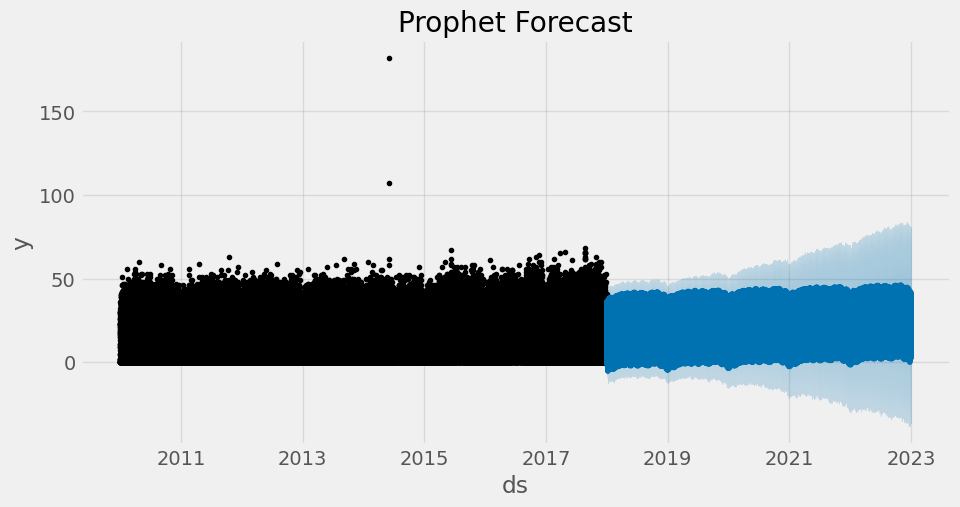

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

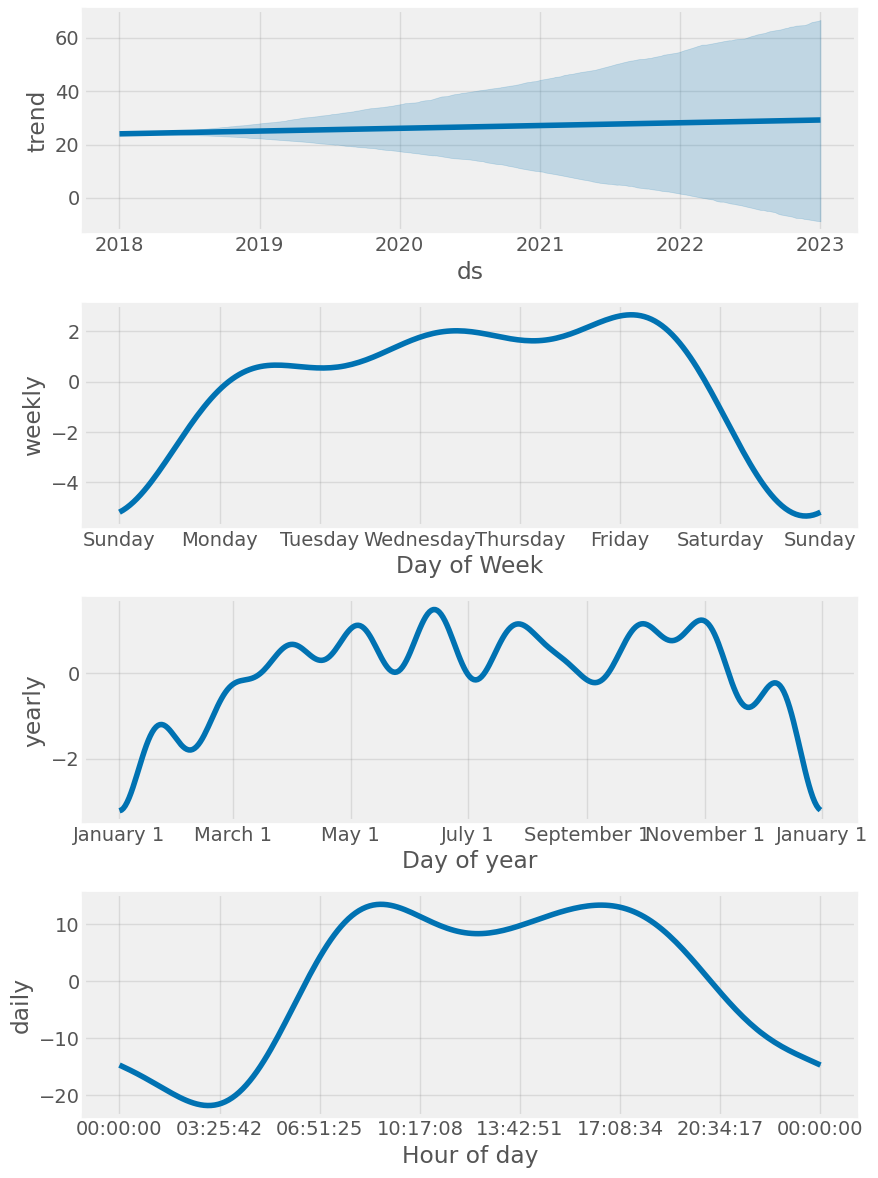

In [20]:
fig = model.plot_components(df_test_fcst)
plt.show()

In [21]:
df_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,24.020583,-0.998464,13.265999,24.020583,24.020583,-18.269190,-18.269190,-18.269190,-14.740748,...,-0.313010,-0.313010,-0.313010,-3.215432,-3.215432,-3.215432,0.0,0.0,0.0,5.751393
1,2018-01-01 01:00:00,24.020701,-3.323575,10.532000,24.020701,24.020701,-20.738588,-20.738588,-20.738588,-17.363648,...,-0.159433,-0.159433,-0.159433,-3.215507,-3.215507,-3.215507,0.0,0.0,0.0,3.282113
2,2018-01-01 02:00:00,24.020819,-7.185566,7.928763,24.020819,24.020819,-23.488983,-23.488983,-23.488983,-20.253680,...,-0.019763,-0.019763,-0.019763,-3.215539,-3.215539,-3.215539,0.0,0.0,0.0,0.531837
3,2018-01-01 03:00:00,24.020938,-8.073062,6.496335,24.020938,24.020938,-24.952610,-24.952610,-24.952610,-21.842897,...,0.105816,0.105816,0.105816,-3.215529,-3.215529,-3.215529,0.0,0.0,0.0,-0.931672
4,2018-01-01 04:00:00,24.021056,-6.378756,8.782970,24.021056,24.021056,-22.937778,-22.937778,-22.937778,-19.939594,...,0.217291,0.217291,0.217291,-3.215475,-3.215475,-3.215475,0.0,0.0,0.0,1.083278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022-12-31 19:00:00,29.207026,-9.419640,68.223164,-8.749853,66.653594,-1.409336,-1.409336,-1.409336,7.113361,...,-5.310952,-5.310952,-5.310952,-3.211745,-3.211745,-3.211745,0.0,0.0,0.0,27.797690
43820,2022-12-31 20:00:00,29.207144,-16.575864,59.575448,-8.750336,66.655437,-7.095335,-7.095335,-7.095335,1.452238,...,-5.335276,-5.335276,-5.335276,-3.212297,-3.212297,-3.212297,0.0,0.0,0.0,22.111809
43821,2022-12-31 21:00:00,29.207263,-23.673065,55.705753,-8.750820,66.657279,-12.990101,-12.990101,-12.990101,-4.442789,...,-5.334507,-5.334507,-5.334507,-3.212805,-3.212805,-3.212805,0.0,0.0,0.0,16.217162
43822,2022-12-31 22:00:00,29.207381,-27.712214,50.213798,-8.751303,66.659122,-17.715465,-17.715465,-17.715465,-9.193235,...,-5.308959,-5.308959,-5.308959,-3.213271,-3.213271,-3.213271,0.0,0.0,0.0,11.491916


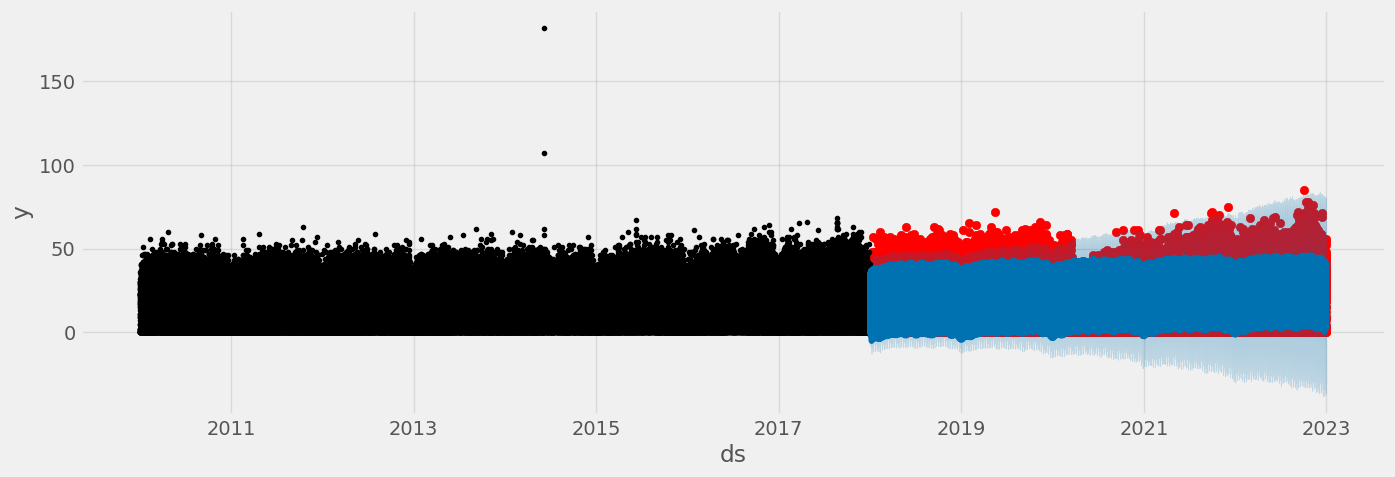

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test['DATE'], df_test['Flights'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

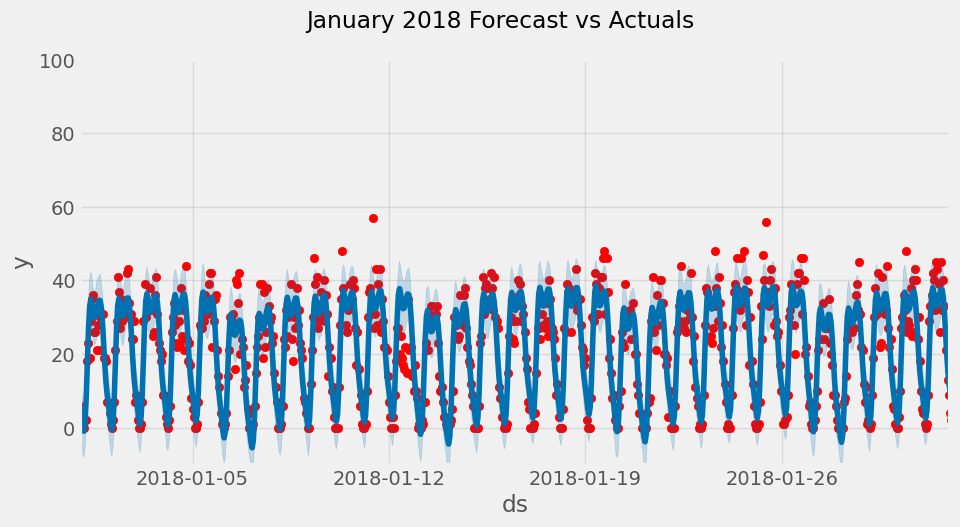

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test['DATE'], df_test['Flights'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
lower = pd.Timestamp('2018-01-01 00:00:00')
upper = pd.Timestamp('2018-02-01 00:00:00')
ax.set_xbound(lower=lower,
              upper=upper)
ax.set_ylim(-10, 100)
plot = plt.suptitle('January 2018 Forecast vs Actuals')

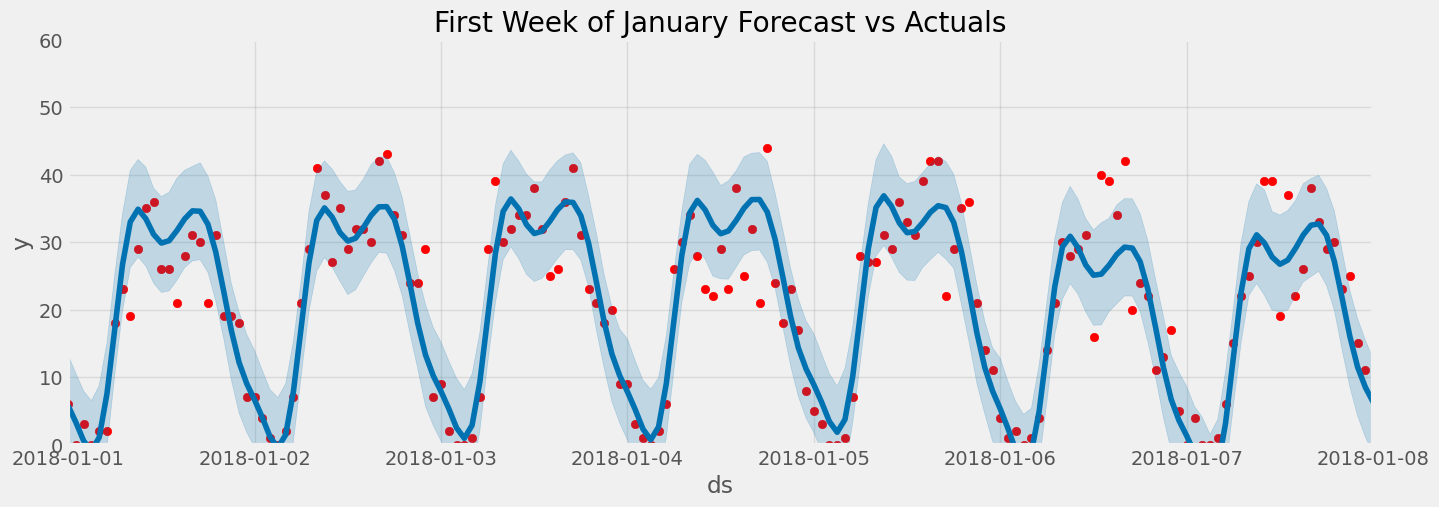

In [24]:
# Plot the forecast with the actuals
lower = pd.Timestamp('2018-01-01 00:00:00')
upper = pd.Timestamp('2018-01-08 00:00:00')
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test['DATE'], df_test['Flights'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=lower, upper=upper)
ax.set_ylim(0, 60)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

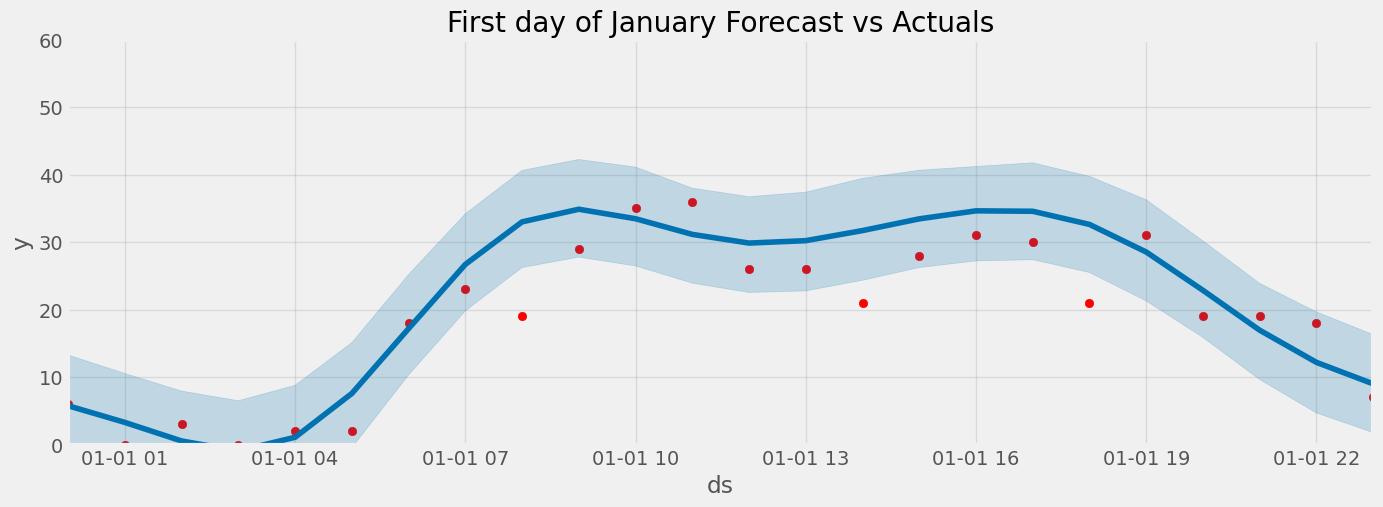

In [25]:
# Plot the forecast with the actuals
lower = pd.Timestamp('2018-01-01 00:00:00')
upper = pd.Timestamp('2018-01-01 23:00:00')
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test['DATE'], df_test['Flights'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=lower, upper=upper)
ax.set_ylim(0, 60)
ax.set_title('First day of January Forecast vs Actuals')
plt.show()

In [26]:
np.sqrt(mean_squared_error(y_true=df_test['Flights'],
                   y_pred=df_test_fcst['yhat']))

8.787364706303494

In [27]:
mean_absolute_error(y_true=df_test['Flights'],
                   y_pred=df_test_fcst['yhat'])

6.833252043706398

# Multiple Regressor

In [28]:
df=pd.read_excel("/home/kamal/Desktop/ULI-3/FinalDataset/BNA(10-22).xlsx")

In [29]:
df['Flights'] = df['Departure'] + df['Arrival']
df.drop(columns=['Departure', 'Arrival','Airport'], inplace=True)
df.head()

,DATE,Wind_Direction,Wind_Speed,cloud_height,vis_distance,Temp,Dew_Point,Slp,Flights
0,2010-01-01 00:00:00,330.000000,3.350000,259.000000,16046.5,278.950000,276.300000,510.350000,9
1,2010-01-01 01:00:00,330.000000,3.100000,762.000000,16093.0,278.150000,275.350000,1021.300000,0
2,2010-01-01 02:00:00,330.000000,2.100000,457.000000,16093.0,278.150000,275.950000,1021.700000,0
3,2010-01-01 03:00:00,343.333333,3.266667,609.333333,16062.0,277.083333,274.216667,681.466667,0
4,2010-01-01 04:00:00,340.000000,4.100000,1036.000000,16093.0,277.050000,273.750000,1022.400000,0


In [30]:
df.rename(columns={'DATE':'ds','Flights':'y'},inplace=True)# date,OT is in modified

df['ds'] = pd.to_datetime(df['ds'])

split_date = pd.Timestamp('2017-12-31 23:00:00')
df_train = df[df['ds'] <= split_date]
df_test = df[df['ds'] > split_date]

In [31]:
model=Prophet()
model.add_regressor('Wind_Direction')
model.add_regressor('Wind_Speed')
model.add_regressor('cloud_height')
model.add_regressor('vis_distance')
model.add_regressor('Temp')
model.add_regressor('Dew_Point')
model.add_regressor('Slp')

In [32]:
model.fit(df_train)

12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# df=df.append(df_test)
future_data=df_test[['ds','Wind_Direction','Wind_Speed','cloud_height','vis_distance','Temp','Dew_Point','Slp']]

In [34]:
forecast_data=model.predict(future_data)
#forecast_data[['ds','yhat','yhat_lower','yhat_upper']]
#forecast_data[['ds']]

In [35]:
np.sqrt(mean_squared_error(y_true=df_test['y'],
                   y_pred=forecast_data['yhat']))

8.792748823305761

In [36]:
mean_absolute_error(y_true=df_test['y'],
                   y_pred=forecast_data['yhat'])

6.838681337281663

In [37]:
correlation_matrix = df.corr()

# Display the correlation with the target variable
print(correlation_matrix['y'].sort_values(ascending=False))

y                 1.000000
ds                0.147179
Dew_Point         0.041982
Temp              0.002873
cloud_height     -0.009299
Wind_Direction   -0.010206
Wind_Speed       -0.018920
Slp              -0.032490
vis_distance     -0.042500
Name: y, dtype: float64
